In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from DataRead import data_read
from OriginModel import *
import time
import numpy as np

In [2]:
## hyper parameters
epoch = 30
batch_size = 32
learning_rate = 0.0001
interval=100
optimizer='adam'
num_k=4
save_epoch=10
seed = 1
datapath = '/home/zsc/ADS_B_select_files_/dataset/Preprocess_64x64_202004xx_to_202011xx.h5'
stime = str(time.asctime( time.localtime(time.time()) )).split(' ')
record_file = './record/'+ stime[-4]+stime[-3]+ '_' +stime[-2]
print(record_file)

./record/Aug28_18:14:35


In [3]:
datasets, dataset_test = data_read(batch_size,datapath)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

G = Feature().to(device)
C1 = Predictor().to(device)
C2 = Predictor().to(device)

opt_g = optim.Adam(G.parameters(),lr=learning_rate, weight_decay=0.0005)
opt_c1 = optim.Adam(C1.parameters(),lr=learning_rate, weight_decay=0.0005)
opt_c2 = optim.Adam(C2.parameters(),lr=learning_rate, weight_decay=0.0005)

In [4]:
def ent(output):
    return - torch.mean(output * torch.log(output + 1e-6))

def discrepancy(out1, out2):
    return torch.mean(torch.abs(F.softmax(out1) - F.softmax(out2)))


In [5]:
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
bestacc = 0
bestmat = np.zeros((34,34))
for i in range(epoch):
    criterion = nn.CrossEntropyLoss().to(device)
    G.train()
    C1.train()
    C2.train()
    torch.cuda.manual_seed(seed)
    if (i+1) % 5 == 0:
            learning_rate /= 2
            update_lr(opt_g, learning_rate)
            update_lr(opt_c1, learning_rate)
            update_lr(opt_c2, learning_rate)
    for batch_idx, data in enumerate(datasets):
        img_t = data['T']
        img_s = data['S']
        label_s = data['S_label'].to(device)
        img_s = img_s.to(device)
        img_t = img_t.to(device)
        opt_g.zero_grad()
        opt_c1.zero_grad()
        opt_c2.zero_grad()
        feat_s = G(img_s)
        output_s1 = C1(feat_s)
        output_s2 = C2(feat_s)
        
        loss_s1 = criterion(output_s1, label_s)
        loss_s2 = criterion(output_s2, label_s)
        loss_s = loss_s1 + loss_s2
        loss_s.backward()
        opt_g.step()
        opt_c1.step()
        opt_c2.step()

        opt_g.zero_grad()
        opt_c1.zero_grad()
        opt_c2.zero_grad()

        feat_s = G(img_s)
        output_s1 = C1(feat_s)
        output_s2 = C2(feat_s)
        feat_t = G(img_t)
        output_t1 = C1(feat_t)
        output_t2 = C2(feat_t)

        loss_s1 = criterion(output_s1, label_s)
        loss_s2 = criterion(output_s2, label_s)
        loss_s = loss_s1 + loss_s2
        loss_dis = discrepancy(output_t1, output_t2)
        loss = loss_s - loss_dis
        loss.backward() 
        opt_c1.step()
        opt_c2.step()

        opt_g.zero_grad()
        opt_c1.zero_grad()
        opt_c2.zero_grad()

        for j in range(num_k):
            feat_t = G(img_t)
            output_t1 = C1(feat_t)
            output_t2 = C2(feat_t)
            loss_dis = discrepancy(output_t1, output_t2)
            loss_dis.backward()
            opt_g.step()
            opt_g.zero_grad()
            opt_c1.zero_grad()
            opt_c2.zero_grad()

        if batch_idx % interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss1: {:.6f}\t Loss2: {:.6f}\t  Discrepancy: {:.6f}'.format(
                    i, batch_idx, 500,
                    100. * batch_idx / 500, loss_s1.item(), loss_s2.item(), loss_dis.item()))
            if record_file:
                    record = open(record_file, 'a+')
                    record.write('%s %s %s\n' % (loss_dis.item(), loss_s1.item(), loss_s2.item()))
                    record.close()
    #  TEST
    G.eval()
    C1.eval()
    C2.eval()
    test_loss = 0
    correct1 = 0
    correct2 = 0
    correct3 = 0
    size = 0
    
    mat = np.zeros((34,34))
    with torch.no_grad():
        for batch_idx, data in enumerate(dataset_test):
            img = data['T']
            label = data['T_label']
            img, label = img.to(device), label.to(device)
            feat = G(img)
            output1 = C1(feat)
            output2 = C2(feat)
            test_loss += F.nll_loss(output1, label).item()
            output_ensemble = output1 + output2
            pred1 = output1.data.max(1)[1]
            pred2 = output2.data.max(1)[1]
            pred_ensemble = output_ensemble.data.max(1)[1]
            k = label.data.size()[0]
            correct1 += pred1.eq(label.data).cpu().sum()
            correct2 += pred2.eq(label.data).cpu().sum()
            correct3 += pred_ensemble.eq(label.data).cpu().sum()
            size += k
            for i,X in enumerate(pred_ensemble):
                
                
                preL = int(X.cpu().detach().numpy())
                trueL = int(label.data[i].cpu().detach().numpy())
                mat[trueL,preL] += 1
        test_loss = test_loss / size
        print('\nTest set: Average loss: {:.4f}, Accuracy C1: {}/{} ({:.0f}%) Accuracy C2: {}/{} ({:.0f}%) Accuracy Ensemble: {}/{} ({:.0f}%) \n'.format(
                test_loss, correct1, size,100. * correct1 / size, correct2, size, 100. * correct2 / size, correct3, size, 100. * correct3 / size))
        if 100. * correct3 / size > bestacc:
            bestacc = 100. * correct3 / size
            bestmat = mat
        if  i % save_epoch == 0:
            torch.save(G,
                    './MCDmodel/%s_epoch%s_G.pt' % (stime[-4]+stime[-3]+ '_' +stime[-2],i))
            torch.save(C1,
                    './MCDmodel/%s_epoch%s_C1.pt' % (stime[-4]+stime[-3]+ '_' +stime[-2],i))
            torch.save(C2,
                    './MCDmodel/%s_epoch%s_C2.pt' % (stime[-4]+stime[-3]+ '_' +stime[-2],i))
        if record_file:
            record = open(record_file, 'a+')
            print('recording :', record_file)
            record.write('acc1:%s acc2:%s acc:%s\n' % (float(correct1) / size, float(correct2) / size, float(correct3) / size))
            record.close()
        

/tmp/ipykernel_1993496/3643798315.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.mean(torch.abs(F.softmax(out1) - F.softmax(out2)))


Train Epoch: 0 [0/500 (0%)]	Loss1: 2.844423	 Loss2: 2.793373	  Discrepancy: 0.007338
Train Epoch: 0 [100/500 (20%)]	Loss1: 2.089647	 Loss2: 2.053973	  Discrepancy: 0.005618
Train Epoch: 0 [200/500 (40%)]	Loss1: 0.870232	 Loss2: 0.855055	  Discrepancy: 0.004587
Train Epoch: 0 [300/500 (60%)]	Loss1: 0.524575	 Loss2: 0.534093	  Discrepancy: 0.003433
Train Epoch: 0 [400/500 (80%)]	Loss1: 0.230444	 Loss2: 0.218197	  Discrepancy: 0.003385

Test set: Average loss: -0.0940, Accuracy C1: 7801/14395 (54%) Accuracy C2: 7626/14395 (53%) Accuracy Ensemble: 7721/14395 (54%) 

recording %s ./record/Aug28_18:14:35
Train Epoch: 1 [0/500 (0%)]	Loss1: 0.100297	 Loss2: 0.097120	  Discrepancy: 0.005076
Train Epoch: 1 [100/500 (20%)]	Loss1: 0.159841	 Loss2: 0.155328	  Discrepancy: 0.002881
Train Epoch: 1 [200/500 (40%)]	Loss1: 0.072855	 Loss2: 0.078889	  Discrepancy: 0.002635
Train Epoch: 1 [300/500 (60%)]	Loss1: 0.027487	 Loss2: 0.024086	  Discrepancy: 0.002398
Train Epoch: 1 [400/500 (80%)]	Loss1: 0.05922

<AxesSubplot:>

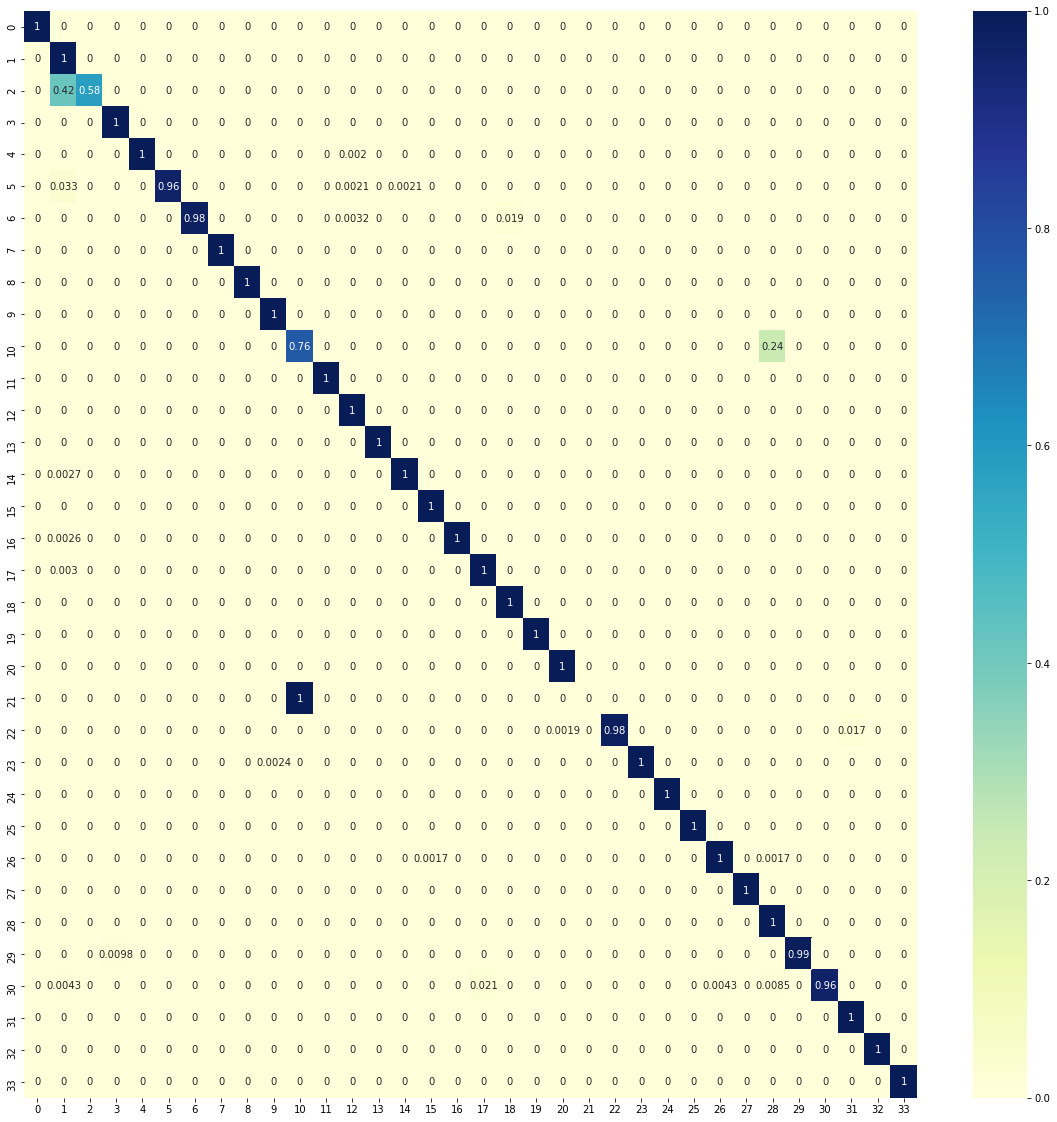

In [6]:
linesum = bestmat.sum(1)
linesum.shape
mat1 = bestmat/bestmat.sum(axis=1 ,keepdims = True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
sns.heatmap(data=mat1,annot=True,cmap= "YlGnBu")